In [78]:
from pathlib import Path
import torch
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.diffusion.configuration_diffusion import DiffusionConfig
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
output_directory = Path("outputs/train/example_lift_diffusion")
output_directory.mkdir(parents=True, exist_ok=True)

training_steps = 5000
device = torch.device("cuda")
log_freq = 250

In [3]:
# Set up the dataset.
delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.images.agentview_image": [-0.1, 0.0],
    "observation.images.robot0_eye_in_hand_image": [-0.1, 0.0],
    "observation.robot0_eef_pos": [-0.1, 0.0],
    "observation.robot0_eef_quat": [-0.1, 0.0],
    "observation.robot0_gripper_qpos": [-0.1, 0.0],
    "observation.state": [-0.1, 0.0],
    # Load the previous action (-0.1), the next action to be executed (0.0),
    # and 14 future actions with a 0.1 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
}
# dataset = LeRobotDataset("lerobot/pusht", delta_timestamps=delta_timestamps)

In [4]:
local_dir = Path("/home/ns1254/lerobot/data") 
dataset = LeRobotDataset(repo_id="lift", root=local_dir, delta_timestamps=delta_timestamps)

In [5]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=64,
    shuffle=True,
    pin_memory=device != torch.device("cpu"),
    drop_last=True,
)

In [6]:
batch = next(iter(dataloader))
for key, value in batch.items():
    print(f"{key}: {value.shape}")

dones: torch.Size([64])
rewards: torch.Size([64])
observation.object: torch.Size([64, 10])
observation.robot0_eef_pos: torch.Size([64, 2, 3])
observation.robot0_eef_quat: torch.Size([64, 2, 4])
observation.robot0_eef_vel_ang: torch.Size([64, 3])
observation.robot0_eef_vel_lin: torch.Size([64, 3])
observation.robot0_gripper_qpos: torch.Size([64, 2, 2])
observation.robot0_gripper_qvel: torch.Size([64, 2])
observation.robot0_joint_pos: torch.Size([64, 7])
observation.robot0_joint_pos_cos: torch.Size([64, 7])
observation.robot0_joint_pos_sin: torch.Size([64, 7])
observation.robot0_joint_vel: torch.Size([64, 7])
observation.state: torch.Size([64, 2, 32])
action: torch.Size([64, 16, 7])
next.done: torch.Size([64])
observation.images.agentview_image: torch.Size([64, 2, 3, 84, 84])
observation.images.robot0_eye_in_hand_image: torch.Size([64, 2, 3, 84, 84])
episode_index: torch.Size([64])
frame_index: torch.Size([64])
timestamp: torch.Size([64])
index: torch.Size([64])
observation.images.agentv

In [7]:
# Set up the the policy.
# Policies are initialized with a configuration class, in this case `DiffusionConfig`.
# For this example, no arguments need to be passed because the defaults are set up for PushT.
# If you're doing something different, you will likely need to change at least some of the defaults.
cfg = DiffusionConfig()

In [8]:
cfg

DiffusionConfig(n_obs_steps=2, horizon=16, n_action_steps=8, input_shapes={'observation.image': [3, 96, 96], 'observation.state': [2]}, output_shapes={'action': [2]}, input_normalization_modes={'observation.image': 'mean_std', 'observation.state': 'min_max'}, output_normalization_modes={'action': 'min_max'}, vision_backbone='resnet18', crop_shape=(84, 84), crop_is_random=True, pretrained_backbone_weights=None, use_group_norm=True, spatial_softmax_num_keypoints=32, use_separate_rgb_encoder_per_camera=False, down_dims=(512, 1024, 2048), kernel_size=5, n_groups=8, diffusion_step_embed_dim=128, use_film_scale_modulation=True, noise_scheduler_type='DDPM', num_train_timesteps=100, beta_schedule='squaredcos_cap_v2', beta_start=0.0001, beta_end=0.02, prediction_type='epsilon', clip_sample=True, clip_sample_range=1.0, num_inference_steps=None, do_mask_loss_for_padding=False)

In [9]:
cfg.input_shapes, cfg.output_shapes

({'observation.image': [3, 96, 96], 'observation.state': [2]}, {'action': [2]})

In [10]:
input_shapes = {'observation.images.agentview_image': (3, 64, 64), 'observation.images.robot0_eye_in_hand_image': (3, 64, 64), 
                'observation.robot0_eef_pos': (3,), 'observation.robot0_eef_quat': (4,), 'observation.robot0_gripper_qpos': (2,),
                'observation.state': (32,)}

output_shapes = {'action': (7,)}

In [11]:
input_shapes

{'observation.images.agentview_image': (3, 64, 64),
 'observation.images.robot0_eye_in_hand_image': (3, 64, 64),
 'observation.robot0_eef_pos': (3,),
 'observation.robot0_eef_quat': (4,),
 'observation.robot0_gripper_qpos': (2,),
 'observation.state': (32,)}

In [12]:
cfg.input_shapes = input_shapes
cfg.output_shapes = output_shapes

In [13]:
print(cfg)

DiffusionConfig(n_obs_steps=2, horizon=16, n_action_steps=8, input_shapes={'observation.images.agentview_image': (3, 64, 64), 'observation.images.robot0_eye_in_hand_image': (3, 64, 64), 'observation.robot0_eef_pos': (3,), 'observation.robot0_eef_quat': (4,), 'observation.robot0_gripper_qpos': (2,), 'observation.state': (32,)}, output_shapes={'action': (7,)}, input_normalization_modes={'observation.image': 'mean_std', 'observation.state': 'min_max'}, output_normalization_modes={'action': 'min_max'}, vision_backbone='resnet18', crop_shape=(84, 84), crop_is_random=True, pretrained_backbone_weights=None, use_group_norm=True, spatial_softmax_num_keypoints=32, use_separate_rgb_encoder_per_camera=False, down_dims=(512, 1024, 2048), kernel_size=5, n_groups=8, diffusion_step_embed_dim=128, use_film_scale_modulation=True, noise_scheduler_type='DDPM', num_train_timesteps=100, beta_schedule='squaredcos_cap_v2', beta_start=0.0001, beta_end=0.02, prediction_type='epsilon', clip_sample=True, clip_sam

In [14]:
input_normalization_mode={
    "observation.images.agentview_image": "mean_std",
    "observation.images.robot0_eye_in_hand_image": "mean_std",
    "observation.robot0_eef_pos": "mean_std",
    "observation.robot0_eef_quat": "mean_std",
    "observation.robot0_gripper_qpos": "mean_std",
    "observation.state": "mean_std",
}
cfg.input_normalization_modes = input_normalization_mode

In [15]:
cfg

DiffusionConfig(n_obs_steps=2, horizon=16, n_action_steps=8, input_shapes={'observation.images.agentview_image': (3, 64, 64), 'observation.images.robot0_eye_in_hand_image': (3, 64, 64), 'observation.robot0_eef_pos': (3,), 'observation.robot0_eef_quat': (4,), 'observation.robot0_gripper_qpos': (2,), 'observation.state': (32,)}, output_shapes={'action': (7,)}, input_normalization_modes={'observation.images.agentview_image': 'mean_std', 'observation.images.robot0_eye_in_hand_image': 'mean_std', 'observation.robot0_eef_pos': 'mean_std', 'observation.robot0_eef_quat': 'mean_std', 'observation.robot0_gripper_qpos': 'mean_std', 'observation.state': 'mean_std'}, output_normalization_modes={'action': 'min_max'}, vision_backbone='resnet18', crop_shape=(84, 84), crop_is_random=True, pretrained_backbone_weights=None, use_group_norm=True, spatial_softmax_num_keypoints=32, use_separate_rgb_encoder_per_camera=False, down_dims=(512, 1024, 2048), kernel_size=5, n_groups=8, diffusion_step_embed_dim=128,

In [16]:
cfg.input_shapes, cfg.input_normalization_modes

({'observation.images.agentview_image': (3, 64, 64),
  'observation.images.robot0_eye_in_hand_image': (3, 64, 64),
  'observation.robot0_eef_pos': (3,),
  'observation.robot0_eef_quat': (4,),
  'observation.robot0_gripper_qpos': (2,),
  'observation.state': (32,)},
 {'observation.images.agentview_image': 'mean_std',
  'observation.images.robot0_eye_in_hand_image': 'mean_std',
  'observation.robot0_eef_pos': 'mean_std',
  'observation.robot0_eef_quat': 'mean_std',
  'observation.robot0_gripper_qpos': 'mean_std',
  'observation.state': 'mean_std'})

In [18]:
# dataset.stats 

In [17]:
policy = DiffusionPolicy(cfg, dataset_stats=dataset.stats)
policy.train()
policy.to(device) 
pass 

In [18]:
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)

In [23]:
ckpt_path=str(output_directory)
ckpt_path

'outputs/train/example_lift_diffusion'

In [28]:
log_freq=100

In [ ]:
# Run training loop.
step = 0
done = False
while not done:
    for batch in dataloader:
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        output_dict = policy.forward(batch)
        loss = output_dict["loss"]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % log_freq == 0:
            print(f"step: {step}/{training_steps} loss: {loss.item():.3f}")
        step += 1
        if step >= training_steps:
            done = True
            print("\nTraining complete.")
            break

if step % (training_steps//10) == 0: 
    savepath=Path(ckpt_path) / f"checkpoint_{step}.pt"
    policy.save_pretrained(savepath)


step: 0/5000 loss: 0.970
step: 100/5000 loss: 0.138
step: 200/5000 loss: 0.082
step: 300/5000 loss: 0.073
step: 400/5000 loss: 0.064
step: 500/5000 loss: 0.079
step: 600/5000 loss: 0.056
step: 700/5000 loss: 0.058
step: 800/5000 loss: 0.046
step: 900/5000 loss: 0.053
step: 1000/5000 loss: 0.043
step: 1100/5000 loss: 0.033
step: 1200/5000 loss: 0.047
step: 1300/5000 loss: 0.030
step: 1400/5000 loss: 0.046
step: 1500/5000 loss: 0.033
step: 1600/5000 loss: 0.029
step: 1700/5000 loss: 0.035
step: 1800/5000 loss: 0.035
step: 1900/5000 loss: 0.047
step: 2000/5000 loss: 0.035
step: 2100/5000 loss: 0.019
step: 2200/5000 loss: 0.023
step: 2300/5000 loss: 0.043
step: 2400/5000 loss: 0.032
step: 2500/5000 loss: 0.026
step: 2600/5000 loss: 0.036
step: 2700/5000 loss: 0.024
step: 2800/5000 loss: 0.036
step: 2900/5000 loss: 0.023
step: 3000/5000 loss: 0.014
step: 3100/5000 loss: 0.022
step: 3200/5000 loss: 0.017
step: 3300/5000 loss: 0.022
step: 3400/5000 loss: 0.025
step: 3500/5000 loss: 0.017
step

In [30]:
savepath

PosixPath('outputs/train/example_lift_diffusion/checkpoint_5000.pt')

In [ ]:
# policy.save_pretrained(savepath)

### offline evaluation

In [70]:
demo_id=0
rows=[]
for i in range(len(dataset)):
    row=dataset[i]
    if row['episode_index'].numpy()!=demo_id:
        break 
    rows.append(row)

for i in range(len(rows)):
    assert i==rows[i]['frame_index'].numpy()

len(rows)

54

In [80]:
actions_org=[]
for row in rows:
    actions_org.append(row['action'][0].numpy())

actions_org=np.array(actions_org)
actions_org.shape

(54, 7)

In [76]:
action_pred=[]
for row in rows:
    input_batch = {k: v.to(device) for k, v in row.items() if k in input_shapes} 
    output_dict = policy.select_action(input_batch)
    action_pred.append(output_dict[0].cpu().numpy())

In [81]:
action_pred=np.array(action_pred)
action_pred.shape

(54, 7)

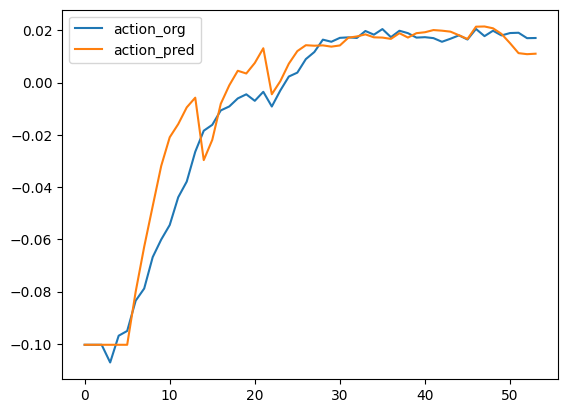

In [91]:
plt.plot(actions_org[:, 0], label="action_org")
plt.plot(action_pred[:, 0], label="action_pred")
plt.legend()

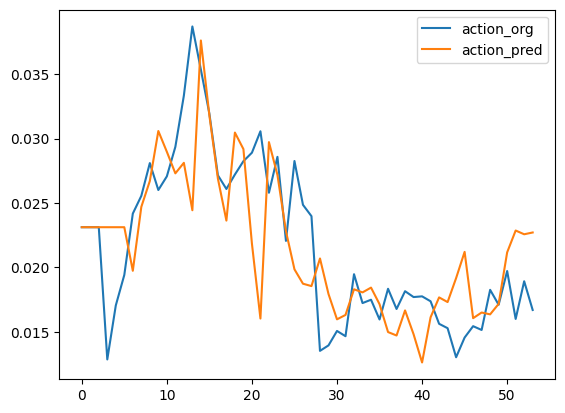

In [90]:
plt.plot(actions_org[:, 1], label="action_org")
plt.plot(action_pred[:, 1], label="action_pred")
plt.legend()

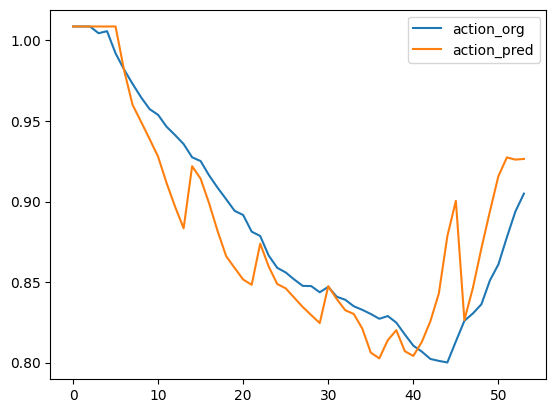

In [89]:
plt.plot(actions_org[:, 2], label="action_org")
plt.plot(action_pred[:, 2], label="action_pred")
plt.legend()